In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i + 1: s for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s[0] = '.'

In [29]:
block_size = 3  # 决定根据多少个字母去预测下一个字母
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s_to_i[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix])
        context = context[1:] + [ix]

In [30]:
import torch

X = torch.Tensor(X).int()
Y = torch.Tensor(Y).long()
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int32, torch.int64)

In [6]:
C = torch.randn((27, 2))
C[5], C[8], C[[5, 6, 8]], C[torch.tensor([5, 6, 8])]

(tensor([-1.0803, -0.9354]),
 tensor([-0.9392,  0.7454]),
 tensor([[-1.0803, -0.9354],
         [-0.4227, -0.1807],
         [-0.9392,  0.7454]]),
 tensor([[-1.0803, -0.9354],
         [-0.4227, -0.1807],
         [-0.9392,  0.7454]]))

In [16]:
C[X]

tensor([[[-0.0886,  1.6839],
         [-0.0886,  1.6839],
         [-0.0886,  1.6839]],

        [[-0.0886,  1.6839],
         [-0.0886,  1.6839],
         [-0.1886, -1.2475]],

        [[-0.0886,  1.6839],
         [-0.1886, -1.2475],
         [ 2.5982,  0.9435]],

        [[-0.1886, -1.2475],
         [ 2.5982,  0.9435],
         [ 2.5982,  0.9435]],

        [[ 2.5982,  0.9435],
         [ 2.5982,  0.9435],
         [-0.3883, -1.7584]],

        [[-0.0886,  1.6839],
         [-0.0886,  1.6839],
         [-0.0886,  1.6839]],

        [[-0.0886,  1.6839],
         [-0.0886,  1.6839],
         [-0.2570, -1.5688]],

        [[-0.0886,  1.6839],
         [-0.2570, -1.5688],
         [ 2.8748, -0.3933]],

        [[-0.2570, -1.5688],
         [ 2.8748, -0.3933],
         [ 0.1534,  0.0773]],

        [[ 2.8748, -0.3933],
         [ 0.1534,  0.0773],
         [-1.4276, -2.2366]],

        [[ 0.1534,  0.0773],
         [-1.4276, -2.2366],
         [ 0.1534,  0.0773]],

        [[-1.4276, -2

In [17]:
C[X].shape

torch.Size([32, 3, 2])

In [26]:
# X[14,2]的值是22， C[X][14,2]其实就是在求C[22]
# 也就是说形成了一个新的矩阵，这个矩阵[14,2]的位置就放的之前C[22]的值，所以原来X(32,3)的矩阵变成了(32,3,2)的矩阵
X[14, 2], C[X][14, 2], C[22]

(tensor(22, dtype=torch.int32),
 tensor([-1.4276, -2.2366]),
 tensor([-1.4276, -2.2366]))

In [7]:
# 把很大的一个X放在一个小的(27,2)的矩阵中
emb = C[X]
# 需要concat其中的每一列，把emb从一个[32,3,2]的矩阵变为一个[32,6]的矩阵
# torch.cat((emb[:,0,:], emb[:,1,:],emb[:,2,:]), 1).shape
# 但如果blocksize发生了变化，就需要手动改这个torch.cat的index，所以我们用unbind方法
# torch.cat(torch.unbind(emb, 1), 1).shape
# 但是这些都不如view高效，view要求内存连续
emb.view(32, 6) == torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [8]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# h = emb.view(32,6) @ W1 + b1
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
h


tensor([[ 0.5953,  0.9568, -0.3601,  ...,  0.9490,  0.0939,  0.9865],
        [-0.3757, -0.7598,  0.8586,  ...,  0.8582,  0.9562, -0.3765],
        [-0.9970, -0.9996,  0.9999,  ...,  0.2961,  0.9998, -0.9939],
        ...,
        [-0.6123, -0.7258,  0.9984,  ...,  0.8007,  0.8594, -0.9459],
        [-0.6416, -0.9924,  0.9999,  ..., -0.8889,  0.9783, -0.9664],
        [-0.3588, -0.8164,  0.9994,  ..., -0.7141,  0.9822, -0.8960]])

In [12]:
# 第二层
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()
probs[0].sum()

"""
当用前5个words时，各个变量的shape：
X = (32,3)  Y=(32,)
C = (27,2)  emb = (32, 3, 2)
W1 = (6, 100) b1 = (100,)
h = (32, 100)
W2 = (100, 27)  b2=(27,)
logits = (32, 27)
probs = (32, 27) 且每行的和是1
probs[torch.arange(32), Y]表示了Y中每一行在probs中的概率，其shape是(32,)
为什么对它调用log函数？
1. 因为对数函数是单调递增的，对接近0的概率值增长非常快，也就意为着对预测错误的样本，对数损失会给更大的惩罚。
2. 当概率是接近0或1的时候，直接用它计算损失，可能会导致数值下溢或上溢
之后就是加起来取平均值，为了去计算最小损失值，给它一个负数
"""

tensor(1.)

In [13]:
Y

tensor([ 5., 13., 13.,  1.,  0., 15., 12.,  9., 22.,  9.,  1.,  0.,  1., 22.,
         1.,  0.,  9., 19.,  1.,  2.,  5., 12., 12.,  1.,  0., 19., 15., 16.,
         8.,  9.,  1.,  0.])

In [16]:
probs[torch.arange(32), Y]

tensor([2.4878e-09, 3.6797e-12, 2.3026e-10, 1.6010e-10, 1.6556e-08, 2.8466e-13,
        8.9345e-19, 1.0790e-13, 4.4661e-13, 4.3844e-05, 2.1446e-06, 2.7384e-01,
        7.8349e-07, 7.4775e-04, 8.3898e-08, 1.9778e-10, 8.5059e-09, 1.4062e-10,
        5.8266e-03, 2.3448e-07, 4.6782e-11, 8.9680e-07, 1.2722e-16, 7.9468e-07,
        1.1243e-07, 2.5356e-12, 1.4194e-10, 1.4363e-05, 3.2039e-13, 3.3227e-09,
        9.7718e-01, 8.7001e-01])

In [21]:
import torch.nn.functional as F

In [67]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

params = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in params))


3481


In [68]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
# 以下三行等于cross_entropy
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

In [64]:
lre = torch.linspace(-3, 0, 1000)
# lrs是10的-3次方至10的0次方之间的1000个数，也就是0.001至1
lrs = 10 ** lre
lri = []
lossi = []

In [76]:
for p in params:
    p.requires_grad = True

for k in range(10000):
    # minibatch construct 只取32行
    ix = torch.randint(0, X.shape[0], (32,))

    # forward
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(f"{k} minibatch loss is {loss.item()}")

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    #update
    # lr = lrs[k]
    # 先用较大的学习率0.1，再逐渐调小，loss更容易降低
    lr = 0.001
    for p in params:
        p.data += -lr * p.grad

    # lossi.append(loss.item())
    # lri.append(lre[k])

In [77]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"total loss is {loss.item()}")

total loss is 2.3861241340637207


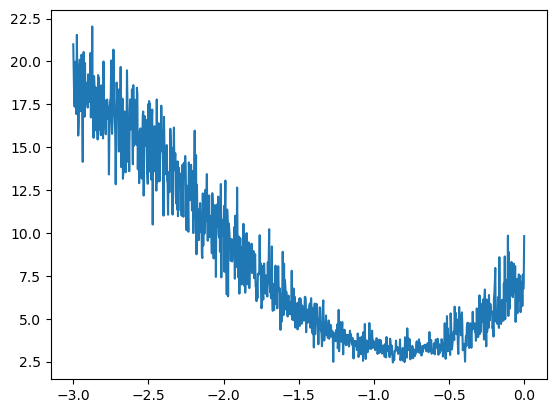

In [66]:
from matplotlib import pyplot as plt

plt.plot(lri, lossi)

In [1]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i + 1: s for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s[0] = '.'

In [2]:
# training split, 用于上面的训练
# dev/validation split, 用于调整超参数
# test split, 用于测试

block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"x.shape is {X.shape}, y.shape is {Y.shape}")
    return X, Y

In [49]:
import random
import torch
import torch.nn.functional as F

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

x.shape is torch.Size([182441, 3]), y.shape is torch.Size([182441])
x.shape is torch.Size([22902, 3]), y.shape is torch.Size([22902])
x.shape is torch.Size([22803, 3]), y.shape is torch.Size([22803])


In [144]:
# 尝试用GPU训练，发现时间会更长，应该是因为主要耗时是for循环操作，而不是向量计算
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Xtrain = Xtrain.to(device=device)
# Ytrain = Ytrain.to(device=device)
device = "cpu"
g = torch.Generator(device=device).manual_seed(2147483647)
# C = torch.randn((27, 10), generator=g, device=device)
# 尝试用一个固定值，做训练后loss能到2.17。如果是上面的随机值，loss能到2.05
C = torch.full((27, 10), 0.5, device=device)
W1 = torch.randn((30, 300), generator=g, device=device)
b1 = torch.randn(300, generator=g, device=device)
W2 = torch.randn((300, 27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)

params = [C, W1, b1, W2, b2]
for p in params:
  p.requires_grad = True
print(sum(p.nelement() for p in params))

17697


In [141]:
for k in range(200000):
    ix = torch.randint(0, Xtrain.shape[0], (128,))

    # forward
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])

    # backward
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in params:
        p.data += -lr * p.grad

In [142]:
# 当前在trainingset的loss
emb = C[Xtrain] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1713, grad_fn=<NllLossBackward0>)

In [143]:
# 当前在dev set的loss
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1873, grad_fn=<NllLossBackward0>)

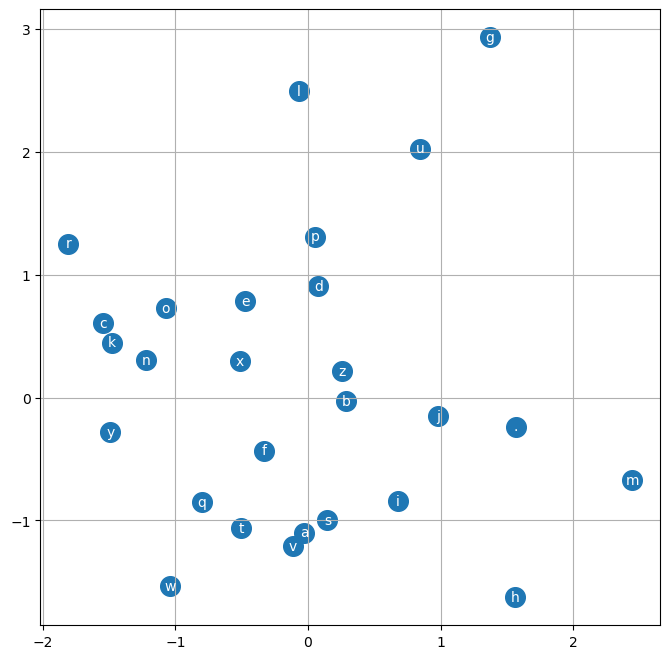

In [15]:
from matplotlib import pyplot as plt
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# 只有在C的shape是(27,2)时才能看到这个图像，以下是训练前的效果
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i_to_s[i], ha="center", va="center", color='white')
plt.grid('minor')

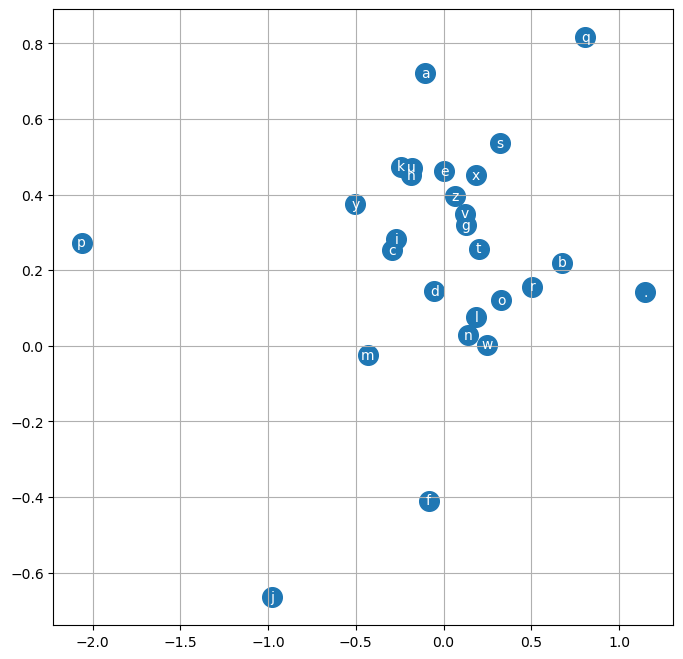

In [110]:
# 二维的C训练后，最低能到2.15多的loss，图像中可以看到aeiou字母的位置较近，q和.就属于比较特殊的字符(后来不小心用10维的C覆盖了，导致看不到效果)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i_to_s[i], ha="center", va="center", color='white')
plt.grid('minor')

In [112]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(i_to_s[i] for i in out))

montaymyah.
seel.
nihahlia.
emmadiendraeg.
adelynnelin.
shivonna.
keiseananaraelyzion.
kalin.
shubergo.
griel.
kindreelynn.
novana.
ubakarder.
yaruemeha.
kayshayton.
azhia.
salynn.
unizabelle.
ren.
crevis.


In [113]:
C

tensor([[ 1.1493e+00,  1.4195e-01,  1.1928e-01, -1.2696e+00,  3.2213e-01,
          8.8627e-02, -1.3128e+00,  7.3317e-01,  2.0498e-01,  6.8876e-01],
        [-1.0397e-01,  7.2175e-01, -2.1446e-01, -6.6167e-02,  1.0880e+00,
          2.4408e+00,  1.4776e+00, -1.6429e+00,  7.7236e-01, -6.0891e-01],
        [ 6.7677e-01,  2.1981e-01, -1.2030e+00,  2.4877e-01,  1.4625e-02,
          1.3124e+00,  8.7588e-01,  5.4833e-01, -9.2019e-01,  1.3118e-03],
        [-2.9307e-01,  2.5258e-01, -3.0217e-01,  5.1346e-01, -2.3140e-01,
          2.0277e-02, -6.3538e-01,  6.8106e-01, -5.0752e-01, -1.7199e-02],
        [-5.2750e-02,  1.4432e-01, -3.5217e-02, -7.4435e-02, -3.7240e-01,
          5.1445e-01, -1.2592e-01,  1.9859e-01, -2.8449e-01, -2.5125e-01],
        [ 4.6386e-03,  4.6146e-01,  3.4016e-01, -4.9285e-01,  6.3691e-02,
          8.0999e-02,  5.2177e-02, -1.2344e-01, -5.3216e-01,  6.2547e-02],
        [-8.5660e-02, -4.0949e-01, -1.2912e+00, -8.6761e-01,  6.0006e-01,
         -6.1580e-01,  1.4784e+0